In [1]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer
from composition_stats import ilr, sbp_basis
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import random

import plotly.io as pio
pio.renderers.default = "svg"

import seaborn as sns
sns.set_theme()

np.random.seed(42)
random.seed(42)

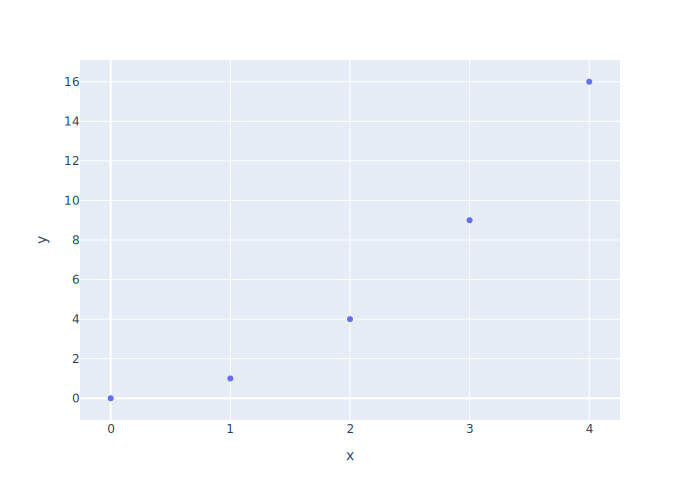

In [2]:
## Code to avoid having a "Loading [MathJax]/extensions/MathMenu.js" message
## in the following generated PDFS by plotly
import plotly.express as px

#garbage graph
fig = px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig.show()
fig.write_image("random.pdf")

In [3]:
import os

out_dir = os.path.join('figures', '4classes')
os.makedirs(out_dir, exist_ok=True)

In [4]:
K = 10         #Index of the instance you want to test in the test set
N_class = 4    #Number of class, the dimension of the simplex is therefore N_class-1
N_feat  = 6    #In this example, since the number of feature of the digit dataset is quite large (64), we propose to reduce it with a PCA

#load the dataset, take a subset of N_class classes, scale it and split into a training and testing set
X, Y = datasets.load_digits(return_X_y=True)
subset_i = np.where(Y < N_class)
X = X[subset_i]
Y = Y[subset_i]
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#Reduce the number of feature to N_feat with a PCA
pca = PCA(n_components=N_feat)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)

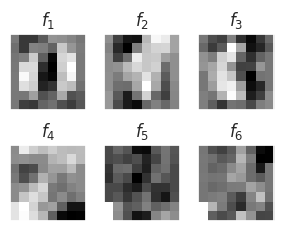

In [5]:
fig, ax_list = plt.subplots(nrows=2, ncols=int(N_feat/2), figsize=(3, 2.5))
for i, (c, ax) in enumerate(zip(pca.components_, ax_list.flatten())):
    ax.set_title(f'$f_{i+1}$')
    ax.imshow(c.reshape([8,8]), cmap='grey')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(out_dir, 'ex_eq4_pca_components.pdf'))

In [6]:
#train an SVM classifier
svc_linear = svm.SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train, Y_train)

SVC(probability=True)

In [7]:
#sbpmatrix = np.array([[1,-1,0,0],[0,0,1,-1],[1,1,-1,-1]])
#basis = sbp_basis(sbpmatrix)
#root = create_tree_from_sbp(sbpmatrix, N_class)

##Visualise the tree using graphviz
#graph = init_graph()
#build_graph(root, graph)
#graph       #plot the bifurcation tree

In [8]:
# Explain all the predictions in the test set
explainer = ShapleyExplainer(svc_linear.predict_proba, X_train, N_class,
                             names_classes=['0','1','2','3'], 
                             names_features=['1st prin. comp.','2nd prin. comp.','3rd prin. comp.','4th prin. comp.','5th prin. comp.','6th prin. comp.'])
(shapley, base) = explainer.explain_instance(np.array(X_test[K]))

print("True label of the tested instance: ", end="")
print(Y_test[K])

#get the model prediction for the Kth instance of the test partition
pred = svc_linear.predict_proba(X_test[K].reshape(1,-1))
print("Prediction on the simplex: ",end="")
print(pred)
ilr_pred = ilr(pred)
print("Prediction in the ILR space: ",end="")
print(ilr_pred)

#The sum of the base distribution and the shapley composition in the ILR space is equal to the predicted probability distribution
sum_shap_base = np.array(shapley).sum(axis=0)+base
print("Sum of the shapley composition and the base distribution in the ILR space: ", end="")
print(sum_shap_base)

[[ 1. -1.  0.  0.]
 [ 1.  1. -1.  0.]
 [ 1.  1.  1. -1.]]
True label of the tested instance: 0
Prediction on the simplex: [[9.95625597e-01 6.30582969e-04 2.03186094e-03 1.71195902e-03]]
Prediction in the ILR space: [5.20747503 2.05118497 1.59876887]
Sum of the shapley composition and the base distribution in the ILR space: [5.20768975 2.05125937 1.59865099]


In [9]:
#SUMMARIZE WITH NORM, COSINE AND INNER PRODUCTS

(norm_shapley, proj_shap_class, cos_shap_shap) = explainer.summarize()


List of the features sorted by their Shapley strength (norm of their Shapley composition):
	 1st prin. comp.: 4.3652157
	 3rd prin. comp.: 1.6488321
	 2nd prin. comp.: 0.8888641
	 4th prin. comp.: 0.3557751
	 5th prin. comp.: 0.1536106
	 6th prin. comp.: 0.1355431

Projection of the Shapley compositions on the class vectors:
		1st prin. comp.	2nd prin. comp.	3rd prin. comp.	4th prin. comp.	5th prin. comp.	6th prin. comp.	
0:        	4.2213493	0.4530502	0.9551210	0.2958573	0.1414223	0.1196375	
1:        	-1.0037985	-0.8704670	0.0553451	-0.1644933	-0.0873685	-0.0998979	
2:        	-2.4463590	0.2496572	0.5433429	0.0852320	0.0073765	-0.0078222	
3:        	-0.7711919	0.1677596	-1.5538090	-0.2165961	-0.0614303	-0.0119174	

Cosine between each Shapley compositions:
		1st prin. comp.	2nd prin. comp.	3rd prin. comp.	4th prin. comp.	5th prin. comp.	6th prin. comp.	
1st prin. comp.:	1.0000000	0.3955064	0.4007030	0.6628460	0.7986310	0.8031885	
2nd prin. comp.:	0.3955064	1.0000000	0.1328092	0.62176

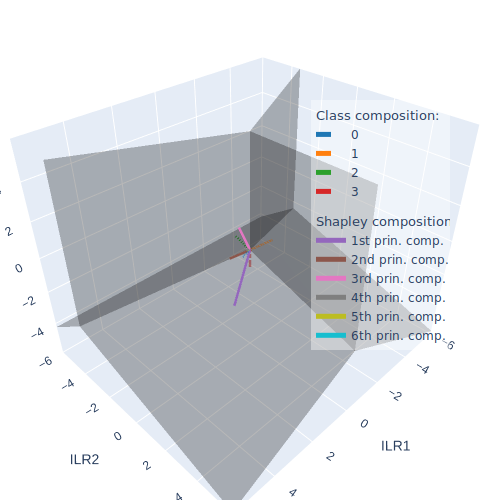

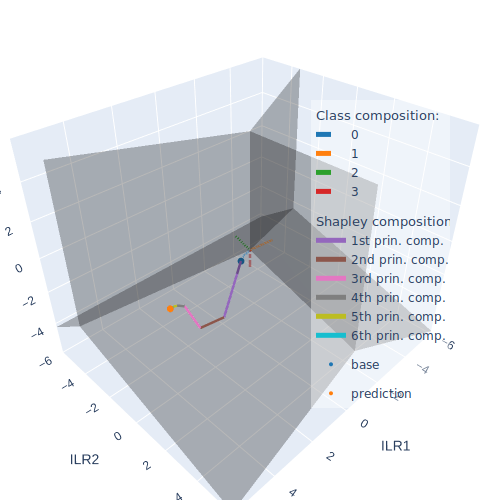

In [10]:
#PLOT the 3D ILR SPACE (CORRESPONDING TO THE CHOSEN ILR COMPONENTS LISTED IN BALANCES).
#plot range [-lim, lim]

#If shapley_sum is True, the sum of the shapley vectors are summed from the base distribution to the prediction

fig = explainer.plot_ilr_space(balances=[1, 2, 3], lim=6, figsize=500)
fig.write_image(os.path.join(out_dir, 'ex_eq4_ilrplot.pdf'))

fig = explainer.plot_ilr_space(balances=[1, 2, 3], shapley_sum=True, lim=6, figsize=500)
fig.write_image(os.path.join(out_dir, 'ex_eq4_ilrplotsum.pdf'))

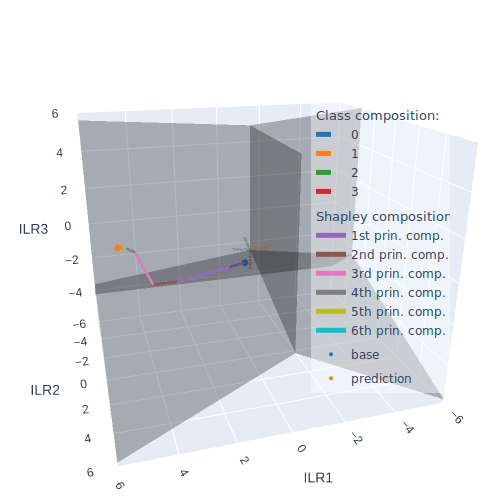

In [11]:
#adjust visulisation angle

camera = dict(
    eye=dict(x=0.6, y=2, z=0.8)
)
fig.update_layout(scene_camera=camera, legend_tracegroupgap=5, legend = dict(font = dict(size = 12)))
fig.show()

fig.write_image(os.path.join(out_dir, 'ex_eq4_ilrplotsum.pdf'), scale=1.5)

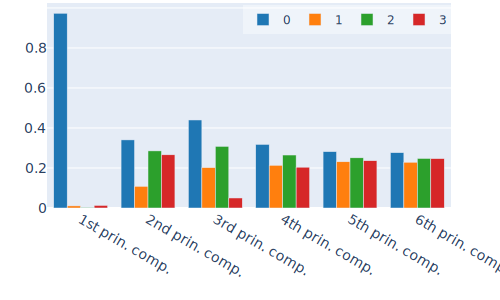

In [12]:
#Plot the Shapley compositions as histograms

fig = explainer.shapley_histogram(figheight=300)
fig.write_image(os.path.join(out_dir, 'ex_eq4_histo.pdf'))

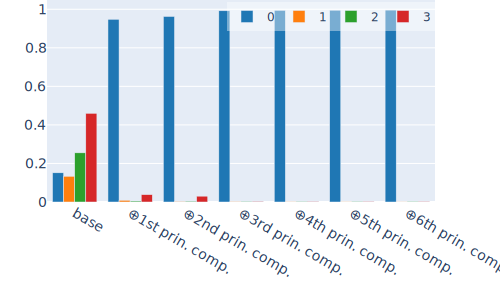

In [13]:
fig = explainer.shapley_histogram_from_base_to_pred(figheight=300)


[0 2 1 3 4 5]
Number of classes = 4
['Base' '$\\oplus PCA_1$' '$\\oplus PCA_3$' '$\\oplus PCA_2$'
 '$\\oplus PCA_4$' '$\\oplus PCA_5$' '$\\oplus PCA_6$']
['0', '1', '2', '3']
[[1.51453788e-01 9.47844323e-01 9.87535631e-01 9.92022358e-01
  9.94243968e-01 9.95053550e-01 9.95626358e-01]
 [1.33349210e-01 9.04100486e-03 4.32133260e-03 1.37974317e-03
  9.28169461e-04 7.61956577e-04 6.30392003e-04]
 [2.55099665e-01 4.95877756e-03 3.61673339e-03 3.04640066e-03
  2.54413543e-03 2.26713686e-03 2.03136892e-03]
 [4.60097337e-01 3.81558943e-02 4.52630295e-03 3.55149853e-03
  2.28372748e-03 1.91735649e-03 1.71188142e-03]]


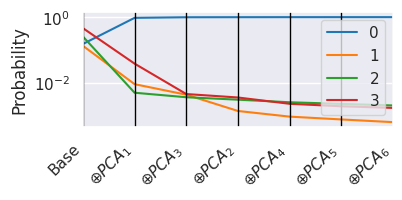

In [14]:
from utils import plot_composite_shapley_feature_contributions


sbpmatrix=explainer.sbpmatrix
basis = sbp_basis(sbpmatrix)

space, b = 'Prob', basis
parname, parallel = 'parallel', True

fig = plt.figure(figsize=(4, 1.5))
ax = fig.add_subplot()
ax.set_yscale('log')
fig, ax = plot_composite_shapley_feature_contributions(np.array(shapley), base=base, cummulative=True,
                                                       sort_by_norm=True, basis=b,
                                                       parallel=parallel,
                                                       feature_names=[f"$\oplus PCA_{j+1}$" for j in range(shapley.shape[0])],
                                                       target_names=[str(i) for i in range(N_class)],
                                                       fig=fig, ax=ax,
                                                       #title=f"Composite Shapley {space} cumsum sorted"
                                                      )

L=ax.legend(loc='upper center', bbox_to_anchor=(0.6, 0.9),
            fancybox=True, shadow=True, ncols=4, handlelength=0.5)

fig.savefig(os.path.join(out_dir, f'comp_shap_{space}_cum_sorted_{parname}'), dpi=300, bbox_inches='tight')